# 基于TensorFlow在 SecretFlow 中实现水平联邦音频分类任务
本教程基于 TensorFlow 的[Simple audio recognition: Recognizing keywords](https://tensorflow.google.cn/tutorials/audio/simple_audio)而改写，通过本教程，您将了解到现有的基于 TensorFlow 的示例如何可以快速地迁移到 SecretFlow 隐语的联邦学习框架之下，实现模型的联邦学习化。

##### Copyright 2020 The TensorFlow Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 单机模式：Simple audio recognition: Recognizing keywords

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [2]:
# !pip install -U -q tensorflow tensorflow_datasets

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2023-10-02 08:11:49.918229: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 08:11:49.920718: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 08:11:50.038066: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 08:11:50.041290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 08:11:51.706224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [4]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.',
        cache_subdir='data',
    )

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['left' 'yes' 'stop' 'up' 'right' 'down' 'no' 'go']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both',
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


2023-10-02 08:11:54.989347: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [8]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [11]:
label_names[[1, 1, 3, 0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

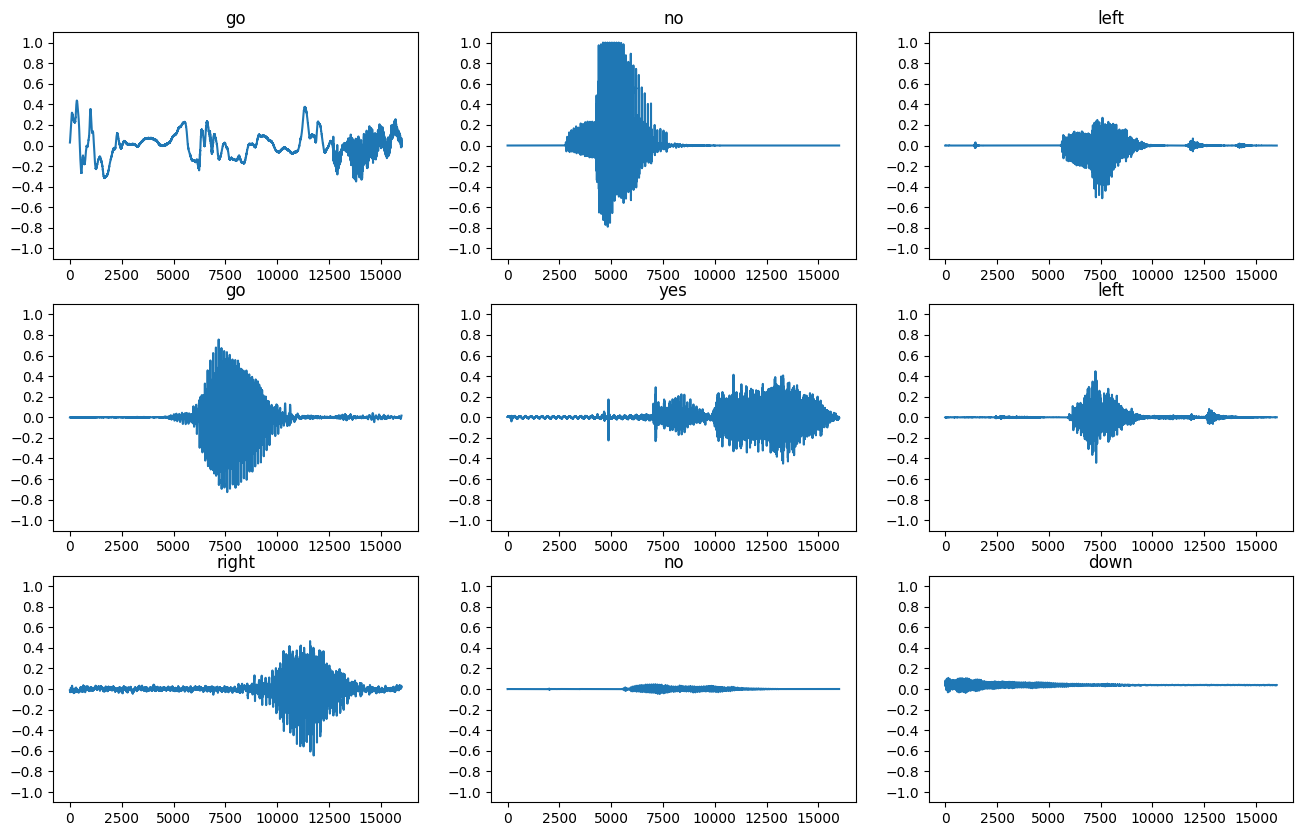

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [13]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

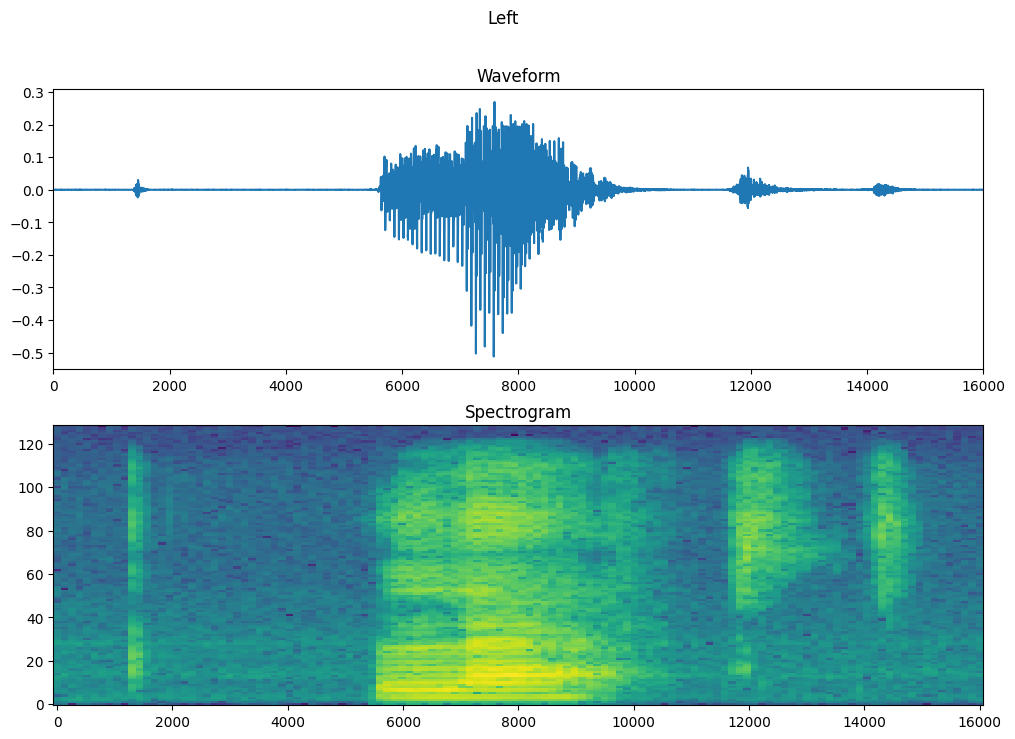

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [17]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

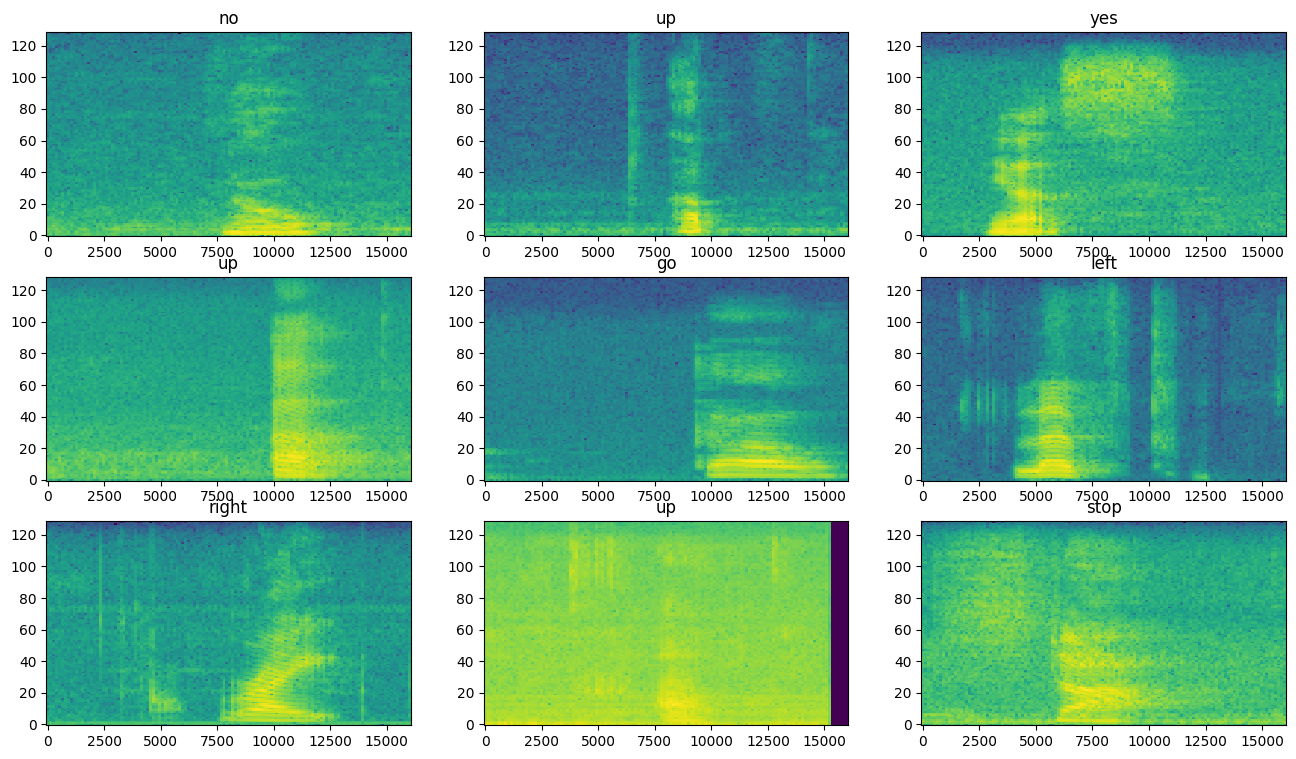

In [20]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [21]:
train_spectrogram_ds = (
    train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential(
    [
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ]
)

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


100/100 [==============================] - 3s 27ms/step - loss: 1.7305 - accuracy: 0.3606 - val_loss: 1.3203 - val_accuracy: 0.5820
Epoch 2/10
100/100 [==============================] - 2s 23ms/step - loss: 1.1775 - accuracy: 0.5748 - val_loss: 0.9405 - val_accuracy: 0.7135
Epoch 3/10
100/100 [==============================] - 2s 24ms/step - loss: 0.9054 - accuracy: 0.6792 - val_loss: 0.7728 - val_accuracy: 0.7669
Epoch 4/10
100/100 [==============================] - 3s 27ms/step - loss: 0.7427 - accuracy: 0.7391 - val_loss: 0.7041 - val_accuracy: 0.7760
Epoch 5/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6330 - accuracy: 0.7725 - val_loss: 0.6225 - val_accuracy: 0.8151
Epoch 6/10
100/100 [==============================] - 2s 23ms/step - loss: 0.5557 - accuracy: 0.8031 - val_loss: 0.5953 - val_accuracy: 0.8008
Epoch 7/10
100/100 [==============================] - 2s 22ms/step - loss: 0.4937 - accuracy: 0.8208 - val_loss: 0.5388 - val_accuracy: 0.8242
Epoch 8/10

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

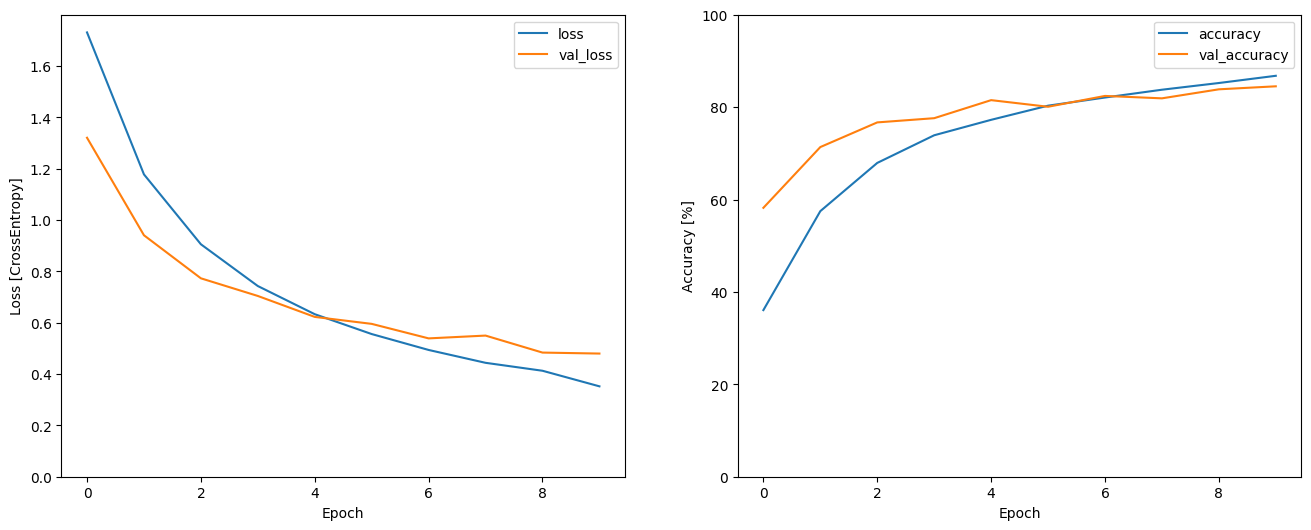

In [25]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(
    history.epoch,
    100 * np.array(metrics['accuracy']),
    100 * np.array(metrics['val_accuracy']),
)
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 12ms/step - loss: 0.4981 - accuracy: 0.8341


{'loss': 0.49814170598983765, 'accuracy': 0.8341346383094788}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [27]:
y_pred = model.predict(test_spectrogram_ds)

 1/13 [=>............................] - ETA: 1s

13/13 [==============================] - 0s 8ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

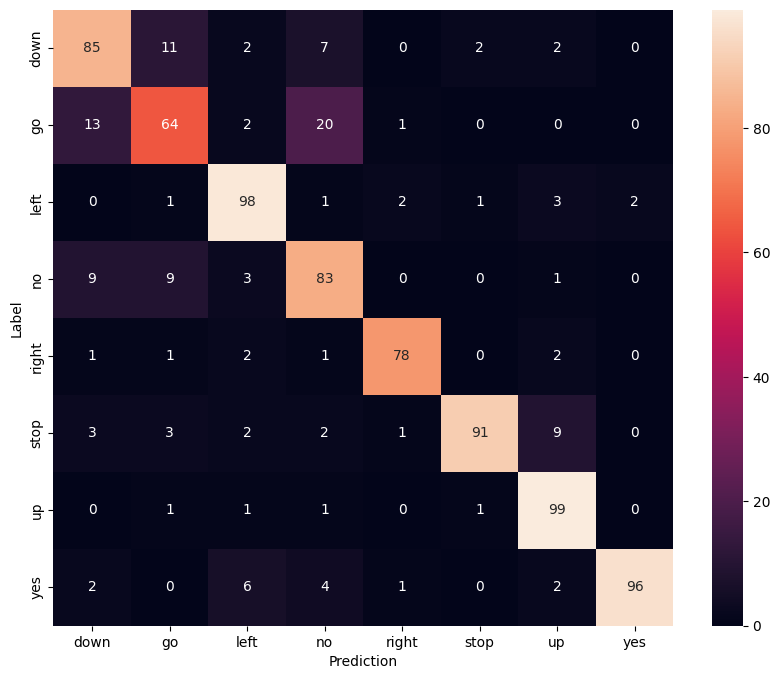

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g'
)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

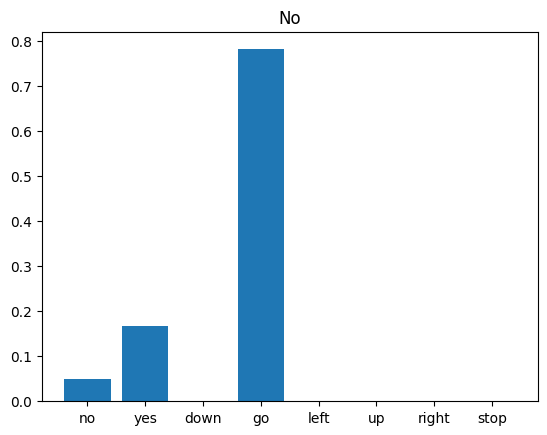

In [31]:
x = data_dir / 'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(
    x,
    desired_channels=1,
    desired_samples=16000,
)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [32]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Accept either a string-filename or a batch of waveforms.
        # YOu could add additional signatures for a single wave, or a ragged-batch.
        self.__call__.get_concrete_function(x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32)
        )

    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it.
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(
                x,
                desired_channels=1,
                desired_samples=16000,
            )
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]

        x = get_spectrogram(x)
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {
            'predictions': result,
            'class_ids': class_ids,
            'class_names': class_names,
        }

Test run the "export" model:

In [33]:
export = ExportModel(model)
export(tf.constant(str(data_dir / 'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.6187872,  2.8469431, -2.993233 ,  4.390452 , -4.5379214,
         -2.6714392, -3.2618747, -1.7490971]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [34]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.6187872,  2.8469431, -2.993233 ,  4.390452 , -4.5379214,
         -2.6714392, -3.2618747, -1.7490971]], dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>}

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The 
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.

# 联邦模式：Simple audio recognition: Recognizing keywords

## 数据集划分
对数据集按参与方进行均匀同分布划分，进行联邦学习参与方的数据集模拟

In [35]:
import os

In [36]:
dataset_name = 'mini_speech_commands'
dataset_path = os.path.join('.', 'data', dataset_name)
parties_list = ['alice', 'bob']
parties_path_list = []

In [37]:
os.path.abspath(dataset_path)

'/home/limingbo/project/oscp/tensorflow-audio-classification/data/mini_speech_commands'

In [38]:
split_dataset_path = os.path.join('.', 'fl-data', dataset_name)

for party in parties_list:
    party_path = os.path.join('.', 'fl-data', dataset_name, party)
    os.makedirs(party_path, exist_ok=True)
    parties_path_list.append(party_path)

In [39]:
parties_path_list

['./fl-data/mini_speech_commands/alice', './fl-data/mini_speech_commands/bob']

In [40]:
commands = os.listdir(dataset_path)

In [41]:
if 'README.md' in commands:
    commands.remove('README.md')
elif '.DS_Store' in commands:
    commands.remove('.DS_Store')

In [42]:
commands

['left', 'yes', 'stop', 'up', 'right', 'down', 'no', 'go']

In [43]:
from os.path import join
import shutil

parties_num = len(parties_list)
for command in commands:
    command_path = join(dataset_path, command)
    for party_path in parties_path_list:
        party_command_path = join(party_path, command)
        print(party_command_path)
        os.makedirs(party_command_path, exist_ok=True)

    index = 0
    for wav_name in os.listdir(command_path):
        wav_path = join(command_path, wav_name)
        target_dir_path = join(
            '.', 'fl-data', dataset_name, parties_list[index % parties_num], command
        )
        shutil.copy(wav_path, target_dir_path)
        print(f'copy {wav_path}-->{target_dir_path}')
        index += 1

./fl-data/mini_speech_commands/alice/left
./fl-data/mini_speech_commands/bob/left
copy ./data/mini_speech_commands/left/2197f41c_nohash_1.wav-->./fl-data/mini_speech_commands/alice/left
copy ./data/mini_speech_commands/left/ece1a95a_nohash_0.wav-->./fl-data/mini_speech_commands/bob/left
copy ./data/mini_speech_commands/left/48bdc11c_nohash_0.wav-->./fl-data/mini_speech_commands/alice/left
copy ./data/mini_speech_commands/left/d37e4bf1_nohash_2.wav-->./fl-data/mini_speech_commands/bob/left
copy ./data/mini_speech_commands/left/e41e41f7_nohash_3.wav-->./fl-data/mini_speech_commands/alice/left
copy ./data/mini_speech_commands/left/ca58a8c6_nohash_1.wav-->./fl-data/mini_speech_commands/bob/left
copy ./data/mini_speech_commands/left/3d3ddaf8_nohash_2.wav-->./fl-data/mini_speech_commands/alice/left
copy ./data/mini_speech_commands/left/e2286c18_nohash_0.wav-->./fl-data/mini_speech_commands/bob/left
copy ./data/mini_speech_commands/left/5b09db89_nohash_3.wav-->./fl-data/mini_speech_commands/a

copy ./data/mini_speech_commands/stop/413997c1_nohash_0.wav-->./fl-data/mini_speech_commands/alice/stop
copy ./data/mini_speech_commands/stop/9ff2d2f4_nohash_1.wav-->./fl-data/mini_speech_commands/bob/stop
copy ./data/mini_speech_commands/stop/f42e234b_nohash_0.wav-->./fl-data/mini_speech_commands/alice/stop
copy ./data/mini_speech_commands/stop/02e85b60_nohash_0.wav-->./fl-data/mini_speech_commands/bob/stop
copy ./data/mini_speech_commands/stop/11379f4d_nohash_0.wav-->./fl-data/mini_speech_commands/alice/stop
copy ./data/mini_speech_commands/stop/3f170018_nohash_0.wav-->./fl-data/mini_speech_commands/bob/stop
copy ./data/mini_speech_commands/stop/57b38f48_nohash_0.wav-->./fl-data/mini_speech_commands/alice/stop
copy ./data/mini_speech_commands/stop/122c5aa7_nohash_0.wav-->./fl-data/mini_speech_commands/bob/stop
copy ./data/mini_speech_commands/stop/8ff44869_nohash_0.wav-->./fl-data/mini_speech_commands/alice/stop
copy ./data/mini_speech_commands/stop/617de221_nohash_1.wav-->./fl-data/

In [44]:
parties_path_list

['./fl-data/mini_speech_commands/alice', './fl-data/mini_speech_commands/bob']

In [45]:
for command in commands:
    for party_path in parties_path_list:
        command_path = join(party_path, command)
        file_num = len(os.listdir(command_path))
        print(f'{command_path} : {file_num}')

./fl-data/mini_speech_commands/alice/left : 500
./fl-data/mini_speech_commands/bob/left : 500
./fl-data/mini_speech_commands/alice/yes : 500
./fl-data/mini_speech_commands/bob/yes : 500
./fl-data/mini_speech_commands/alice/stop : 500
./fl-data/mini_speech_commands/bob/stop : 500
./fl-data/mini_speech_commands/alice/up : 500
./fl-data/mini_speech_commands/bob/up : 500
./fl-data/mini_speech_commands/alice/right : 500
./fl-data/mini_speech_commands/bob/right : 500
./fl-data/mini_speech_commands/alice/down : 500
./fl-data/mini_speech_commands/bob/down : 500
./fl-data/mini_speech_commands/alice/no : 500
./fl-data/mini_speech_commands/bob/no : 500
./fl-data/mini_speech_commands/alice/go : 500
./fl-data/mini_speech_commands/bob/go : 500


## 隐语环境初始化

In [46]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'charlie'], address="local", log_to_driver=False)

alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.2.0.dev20230918


2023-10-02 08:12:36,285	INFO worker.py:1538 -- Started a local Ray instance.


## 封装 DataBuilder

在迁移过程，对于数据集的预处理方式，联邦学习模式和单机模式是一样的，我们不再重复。为了完成迁移适配过程，我们只需要参考[在 SecretFlow 中使用自定义 DataBuilder（TensorFlow）](https://www.secretflow.org.cn/docs/secretflow/latest/zh-Hans/tutorial/CustomDataLoaderTF) 封装我们自定义 DataBuilder 即可。现在，参考原教程，我们封装对应的DataBuilder。

In [47]:
def create_dataset_builder(
    batch_size=32,
):
    def dataset_builder(folder_path, stage="train"):
        import math

        import tensorflow as tf

        dataset = tf.keras.utils.audio_dataset_from_directory(
            directory=folder_path,
            batch_size=batch_size,
            validation_split=0.2,
            seed=0,
            output_sequence_length=16000,
            subset='both',
        )
        # dataset split
        train_dataset = dataset[0]
        eval_dataset = dataset[1]
        # audio preprocess
        train_dataset = train_dataset.map(squeeze, tf.data.AUTOTUNE)
        eval_dataset = eval_dataset.map(squeeze, tf.data.AUTOTUNE)

        train_dataset = make_spec_ds(train_dataset)
        eval_dataset = make_spec_ds(eval_dataset)

        # cache
        train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
        eval_dataset = eval_dataset.cache().prefetch(tf.data.AUTOTUNE)

        # split process
        if stage == "train":
            train_step_per_epoch = len(train_dataset)
            return train_dataset, train_step_per_epoch
        elif stage == "eval":
            eval_step_per_epoch = len(eval_dataset)
            return eval_dataset, eval_step_per_epoch

    return dataset_builder

## 构建 dataset_builder_dict

In [48]:
data_builder_dict = {
    alice: create_dataset_builder(
        batch_size=32,
    ),
    bob: create_dataset_builder(
        batch_size=32,
    ),
}

## 定义网络结构
得益于隐语优异的设计，我们只需要将单机模式下定义的网络结构，进行适当的封装即可，这里为了便于演示，我们去除原来的网络结构中依赖数据集的正则化层`norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))`

In [49]:
from tensorflow.keras import layers
from tensorflow.keras import models


def create_audio_classification_model(input_shape, num_classes, name='model'):
    def create_model():
        from tensorflow import keras

        # Create model

        # Instantiate the `tf.keras.layers.Normalization` layer.
        # norm_layer = layers.Normalization()
        # Fit the state of the layer to the spectrograms
        # with `Normalization.adapt`.
        # delete: norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

        model = models.Sequential(
            [
                layers.Input(shape=input_shape),
                # Downsample the input.
                layers.Resizing(32, 32),
                # Normalize.
                # delete: norm_layer,
                layers.Conv2D(32, 3, activation='relu'),
                layers.Conv2D(64, 3, activation='relu'),
                layers.MaxPooling2D(),
                layers.Dropout(0.25),
                layers.Flatten(),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(num_classes),
            ]
        )

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
        )
        return model

    return create_model

In [50]:
from secretflow.ml.nn import FLModel
from secretflow.security.aggregation import SecureAggregator

## 定义TensorFlow 后端的 FLModel 

In [51]:
device_list = [alice, bob]
aggregator = SecureAggregator(charlie, [alice, bob])

# prepare model
num_classes = 8
input_shape = (124, 129, 1)

# keras model
model = create_audio_classification_model(input_shape, num_classes)


fed_model = FLModel(
    device_list=device_list,
    model=model,
    aggregator=aggregator,
    backend="tensorflow",
    strategy="fed_avg_w",
    random_seed=1234,
)

In [52]:
parties_path_list

['./fl-data/mini_speech_commands/alice', './fl-data/mini_speech_commands/bob']

In [53]:
data = {
    alice: parties_path_list[0],
    bob: parties_path_list[1],
}

In [54]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=20,
    batch_size=32,
    aggregate_freq=2,
    sampler_method="batch",
    random_seed=1234,
    dp_spent_step_freq=1,
    dataset_builder=data_builder_dict,
)

100%|██████████| 100/100 [00:16<00:00,  6.19it/s, epoch: 20/20 -  loss:0.3066645562648773  accuracy:0.9020000100135803  val_loss:0.5432461500167847  val_accuracy:0.8293750286102295 ]


## 可视化训练结果

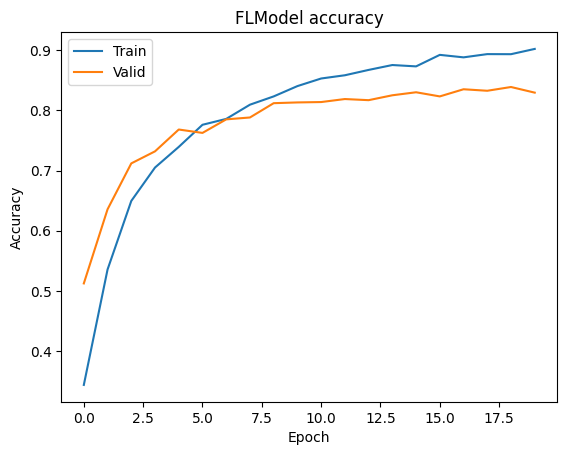

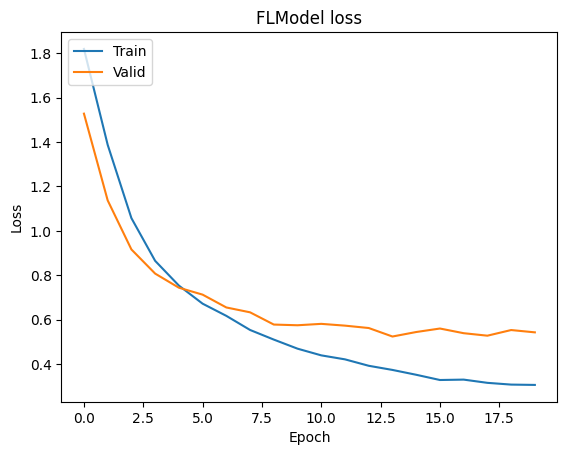

In [55]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history.global_history['accuracy'])
plt.plot(history.global_history['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()